# Quantum Simulation for Quantum Computing Club Talk
A notebook for the talk on quantum simulation given by Cameron Cogburn to the RPI Quantum Computing Club on October 23, 2024.

## Imports

In [2]:
import numpy as np
import scipy as sp
import scipy as sc


from typing import Union, List
import warnings
warnings.filterwarnings('ignore')

from numpy import sqrt

from qiskit.circuit import Parameter
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import SuzukiTrotter
from qiskit.providers.fake_provider import Fake20QV1
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator

from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister #, Gate
from qiskit.transpiler import PassManager

 
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.visualization import array_to_latex
 

from qiskit.synthesis import SuzukiTrotter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit import transpile

from qiskit_aer import AerSimulator

from qiskit_ibm_provider import IBMProvider



# A first example

Here we look at the example of three spin-1/2 particles initialized in the state $| \hspace{-0.1cm} \uparrow \uparrow \uparrow \rangle$ subject to the Hamiltonian
\begin{equation}
\hat{H}_\text{s} = \omega( \hat{\sigma}_x \otimes \hat{\sigma}_y \otimes \hat{\sigma}_z  )
\end{equation}

In [4]:
omega = 1
Ham = SparsePauliOp.from_list([("XYZ", omega)]) 
#Ham1 = SparsePauliOp.from_list([("XII", omega), ("IYI", omega), ("IIZ", omega)]) 

Always good to look at the matrix structure visually.

In [27]:
array_to_latex(Ham)

<IPython.core.display.Latex object>

The observable we are interested in is the magnetization of the system $\langle \sigma_z \rangle = \frac{1}{3} \sum_{i=1}^3 \langle \sigma_z^{(i)} \rangle$.

In [48]:
# Hamiltonian parameters
omega = 1

# Time evolution paramaters
t_start = 0
t_max = 3
dt = 0.2
time_step_list_exact = np.linspace(t_start, t_max, (int((t_max - t_start)/dt))+1)
exact_times = time_step_list_exact

# Initial state
initial_state = Statevector.from_label('000')

# Observables
observable_mag = SparsePauliOp.from_list([ ("ZII", omega), ("IZI", omega), ("IIZ", omega)   ])

# Compute the exact evolution using the exp
H_array = Ham.to_matrix()
exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times]
exact_obs_mag = np.real([sv.expectation_value(observable_mag) for sv in exact_evolution])

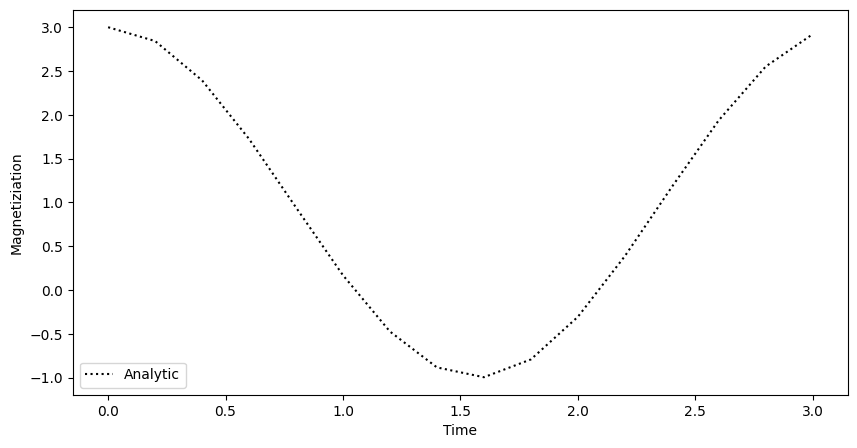

In [49]:
plt.figure(figsize=(10,5))
plt.plot(time_step_list_exact, exact_obs_mag, 'k:',label='Analytic')
#plt.plot(time_step_list_exact, exact_obs_mag1, 'k:',label='Analytic')
plt.xlabel('Time')
plt.ylabel('Magnetiziation')
plt.legend()
plt.show()

# Make circuit by hand

The magnetization is given by $\langle \sigma_z \rangle = \frac{1}{L} \sum_{i=1}^{2^L} p_i \langle e_i | \sigma_z | e_i \rangle$,
where $|e_i\rangle$ are the computational basis states with probability $p_i$ $(|e_i \rangle = |000\rangle, |001\rangle, \dots, |111\rangle )$. To measure this from a bit string, we simply assign 0 for 'up' and 1 for 'down' and then calculate the difference to find the magnetization for a particular bit string. 

In [6]:
def digit_sum(n):
    num_str = str(n)
    zero, one = 0, 0
    sum = 0
    for i in range(0, len(num_str)):
        if int(num_str[i]) == 0:
            zero = zero + 1
        elif int(num_str[i]) == 1:
            one = one + 1
    return zero - one

Time =  0.0
Time =  0.1
Time =  0.2
Time =  0.30000000000000004
Time =  0.4
Time =  0.5
Time =  0.6000000000000001
Time =  0.7000000000000001
Time =  0.8
Time =  0.9
Time =  1.0
Time =  1.1
Time =  1.2000000000000002
Time =  1.3
Time =  1.4000000000000001
Time =  1.5
Time =  1.6
Time =  1.7000000000000002
Time =  1.8
Time =  1.9000000000000001
Time =  2.0
Time =  2.1
Time =  2.2
Time =  2.3000000000000003
Time =  2.4000000000000004
Time =  2.5
Time =  2.6
Time =  2.7
Time =  2.8000000000000003
Time =  2.9000000000000004
Time =  3.0


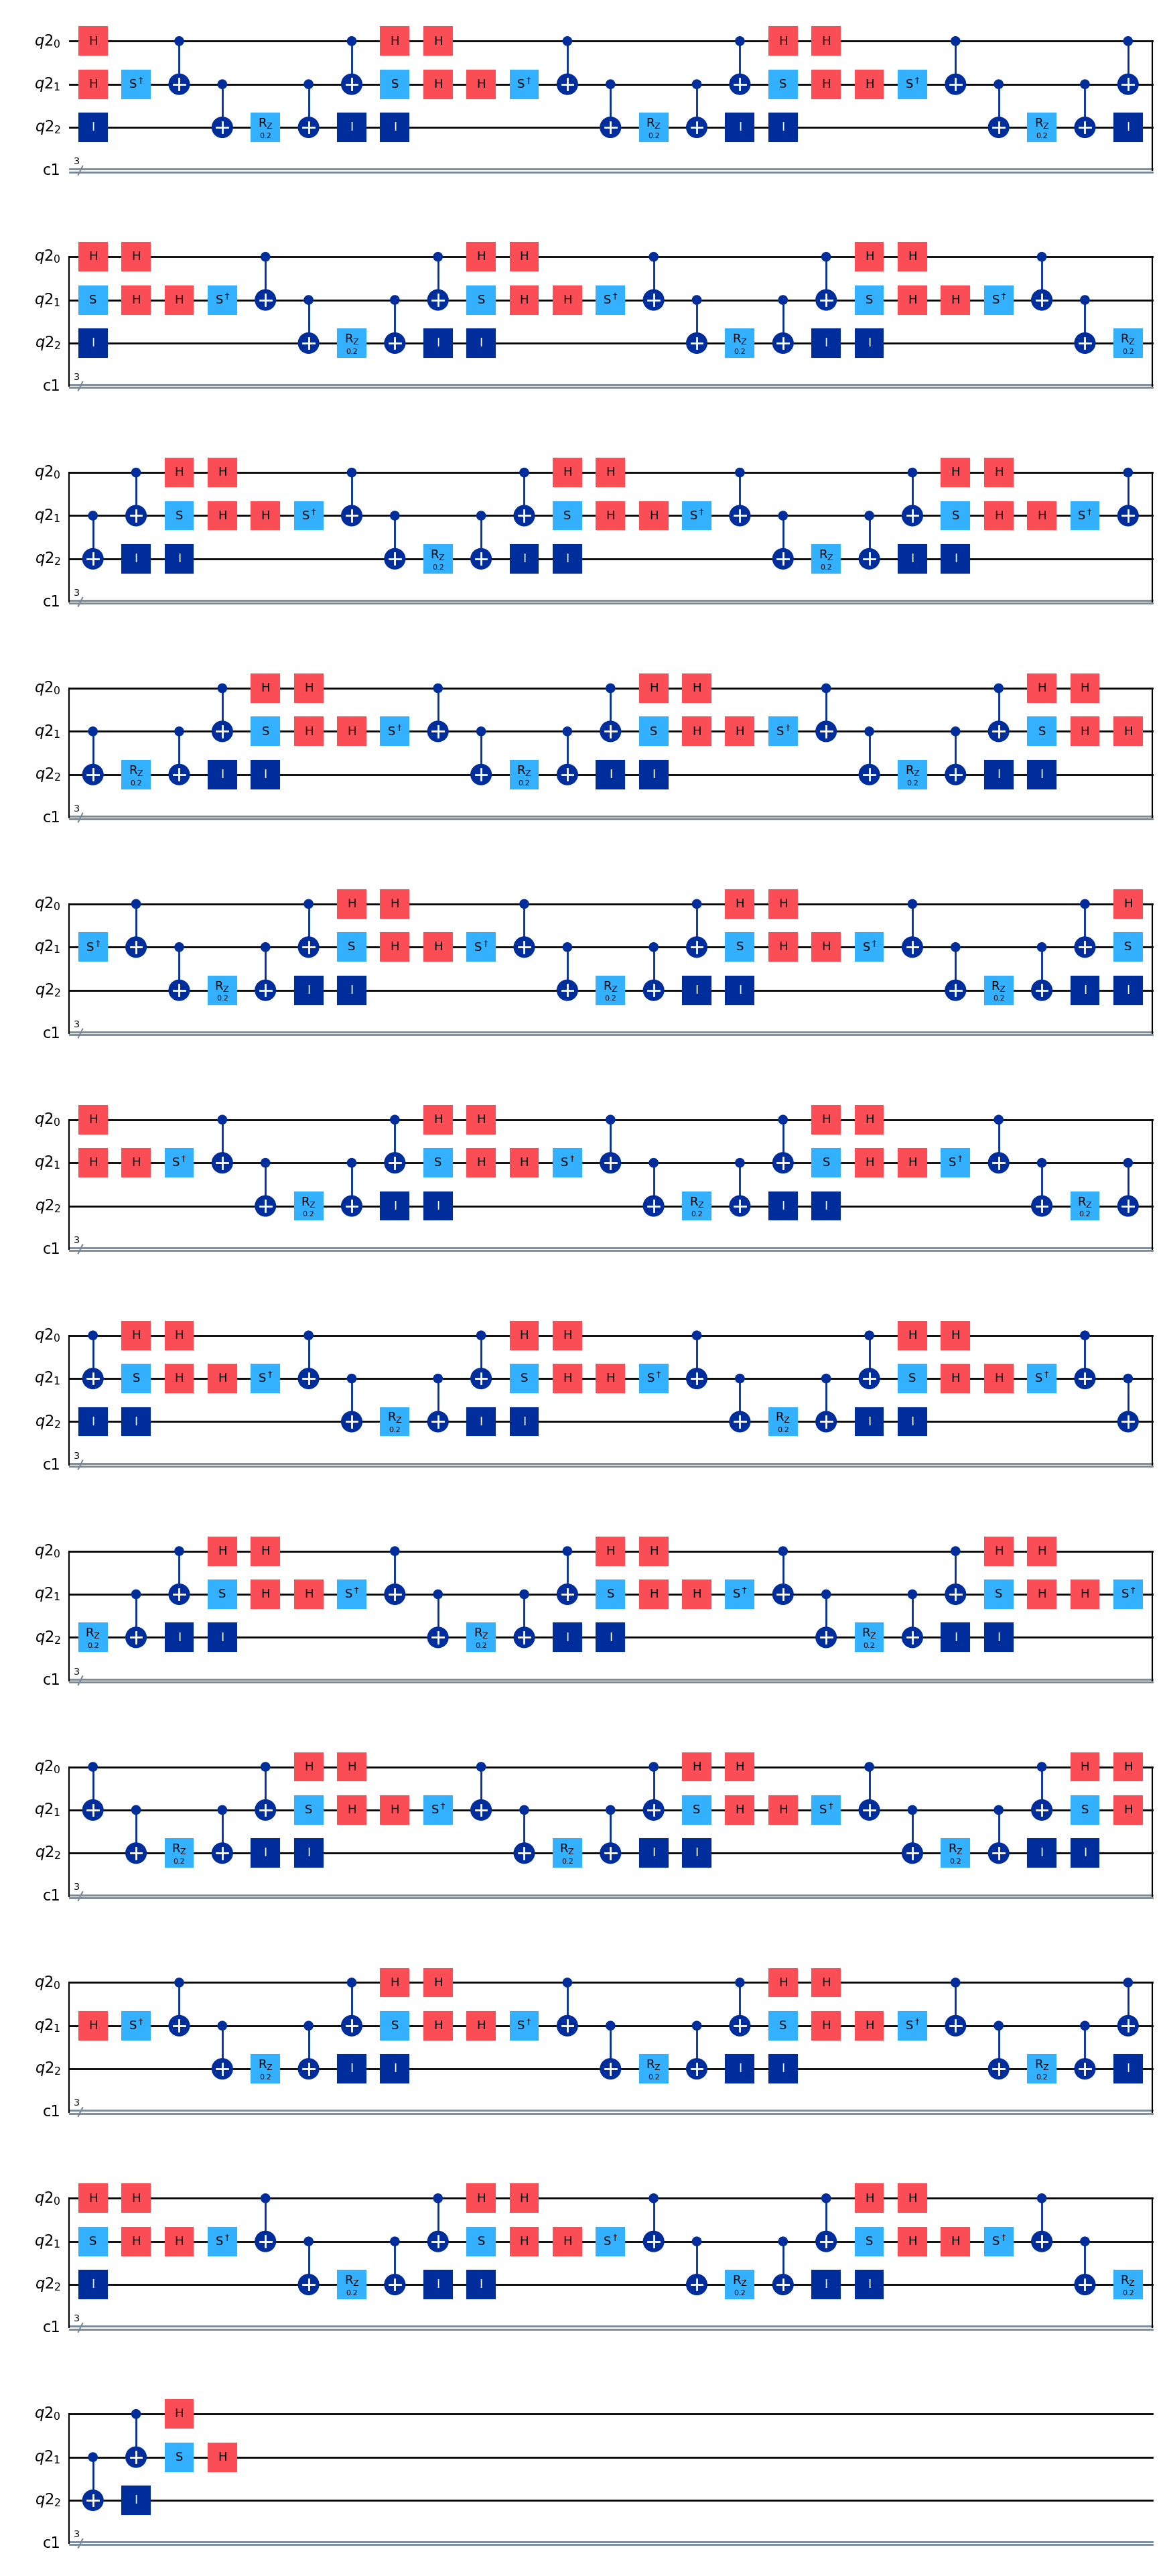

In [7]:
# parameters
a=1
N=3
aer_sim = AerSimulator()
backend = aer_sim
#backend = provider.get_backend("ibm_rensselaer")

t_start = 0
t_max = 3
dt = 0.1
shots = 10000
time_step_max = int(t_max/dt)

# quantum and measurement circuits
N = Ham.num_qubits
qr = QuantumRegister(N)
cr = ClassicalRegister(N)
qc = QuantumCircuit(qr,cr)
qc_meas = QuantumCircuit(qr,cr)
qc_meas.measure(qr,cr)

# lists for outputs
time_list_sim = []
mag_sim = []


# time evolution loop
for time_step in range(time_step_max+1):
    print("Time = ", dt*time_step)

    # construct circuit V_t 'by hand'
    qc.h(qr[0])
    qc.h(qr[1])
    qc.sdg(qr[1])
    qc.id(qr[2])

    qc.cx(qr[0], qr[1])
    qc.cx(qr[1], qr[2])

    qc.rz(2*omega*dt, qr[2])

    qc.cx(qr[1], qr[2])
    qc.cx(qr[0], qr[1])

    qc.h(qr[0])
    qc.s(qr[1])
    qc.h(qr[1])
    qc.id(qr[2])

    # transpile circuit, run job on backend
    qc_total = qc.compose(qc_meas)
    qc_trans = transpile(qc_total.decompose().decompose(), backend=backend, optimization_level=3) #, initial_layout=[0,1,2])
    job = backend.run(qc_trans, shots=shots)

    result = job.result() 
    counts = result.get_counts()
    r1=list(counts.keys())
    r2=list(counts.values())
    
    # calculate magnetization from the bitstrings
    M=0
    for k in range(0,len(r1)):
        M=M+(digit_sum(r1[k]))*r2[k]/shots
    mag_sim.append(M)
 
    time_list_sim.append(dt*time_step) 

qc.draw(output='mpl')

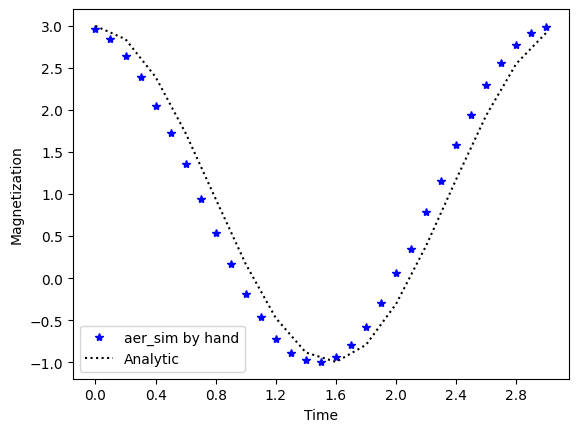

In [52]:
plt.plot(time_list_sim, mag_sim, 'b*', label='aer_sim by hand')
plt.plot(time_step_list_exact, exact_obs_mag, 'k:',label='Analytic')
plt.xlabel('Time')
plt.ylabel('Magnetization')
plt.xticks(np.arange(min(time_list_sim), max(time_list_sim)+0.2, 0.4))
#plt.title(r'Magnetization')
plt.legend()
plt.show()

# Using built-in Pauli Evolution Gate

In [53]:
#backend = provider.get_backend("ibm_rensselaer")
a=1
N=3
backend = aer_sim

t_start = 0
t_max = 3
dt = 0.1
shots = 10000
time_step_max = int(t_max/dt)
time_step_list1 = np.linspace(t_start, t_max, (int((t_max - t_start)/dt))+1)


virtual_pub_list = []
pub_list = []
observable_corr = SparsePauliOp.from_list([ ("ZII", omega), ("IZI", omega), ("IIZ", omega)   ])

circuit = QuantumCircuit(N, N)


for t in time_step_list1:
    print("t = ", t)
    evo_op = PauliEvolutionGate(Ham, dt, synthesis=SuzukiTrotter(order=2, reps=1))
    circuit.append(evo_op.definition, list(range(N)))

    # For doing a simulation using Aer_Sim 
    virtual_pub_list.append((circuit.decompose().decompose(), observable_corr))

    # For actual hardware
    pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
    pm_circuit = pm.run(circuit)
    pm_corr = observable_corr.apply_layout(pm_circuit.layout)
    pub_list.append((pm_circuit, pm_corr))

t =  0.0
t =  0.1
t =  0.2
t =  0.30000000000000004
t =  0.4
t =  0.5
t =  0.6000000000000001
t =  0.7000000000000001
t =  0.8
t =  0.9
t =  1.0
t =  1.1
t =  1.2000000000000002
t =  1.3
t =  1.4000000000000001
t =  1.5
t =  1.6
t =  1.7000000000000002
t =  1.8
t =  1.9000000000000001
t =  2.0
t =  2.1
t =  2.2
t =  2.3000000000000003
t =  2.4000000000000004
t =  2.5
t =  2.6
t =  2.7
t =  2.8000000000000003
t =  2.9000000000000004
t =  3.0


In [54]:
from qiskit_aer import AerSimulator
aer_sim = AerSimulator(method='statevector')

sim_estimator = Estimator(aer_sim) # run on simulator

sim_job = sim_estimator.run(virtual_pub_list, precision=1/np.sqrt(shots))
sim_result = sim_job.result()
sim_mag_values = [sim_result[i].data.evs for i in range(len(pub_list))]

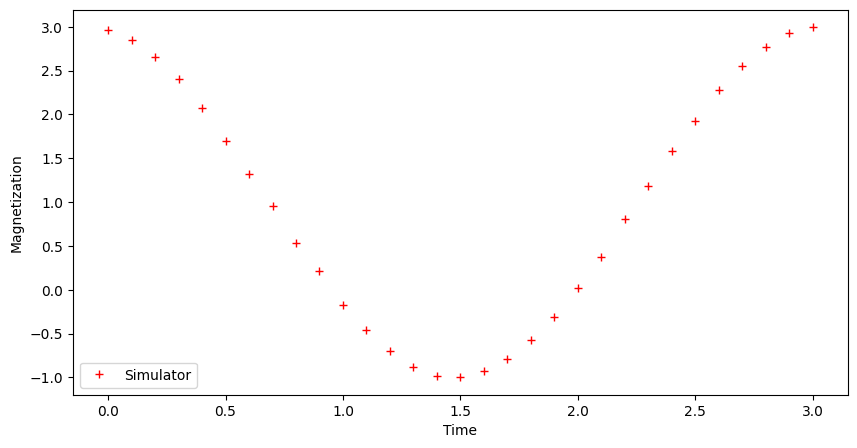

In [55]:
plt.figure(figsize=(10,5))
#plt.plot(time_step_list, cc_values, 'b*',label='ibm_rennselaer')
plt.plot(time_step_list1, sim_mag_values, 'r+',label='Simulator')
plt.xlabel('Time')
plt.ylabel('Magnetization')
plt.legend()
#plt.title('Gate-based time evolution of $\{N_s,M,p\}$={'+str(Ns)+','+str(M)+','+str(p)+'}, $\{\Delta,\omega,g\}$={'+str(delta)+', '+str(omega)+', '+str(g)+'}' )
plt.show()

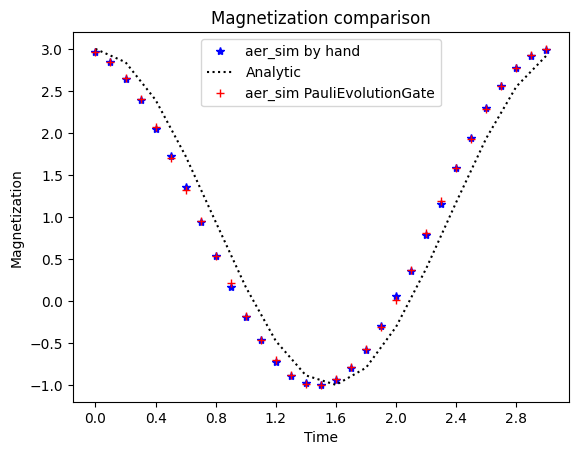

In [56]:
plt.plot(time_list_sim, mag_sim, 'b*', label='aer_sim by hand')
plt.plot(time_step_list_exact, exact_obs_mag, 'k:',label='Analytic')
plt.plot(time_step_list1, sim_mag_values, 'r+',label='aer_sim PauliEvolutionGate')
plt.xlabel('Time')
plt.ylabel('Magnetization')
plt.xticks(np.arange(min(time_step_list_exact), max(time_step_list_exact)+0.2, 0.4))
plt.title(r'Magnetization comparison')
plt.legend()
plt.show()

# Now do on the quantum hardware

In [57]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_provider import IBMProvider
provider = IBMProvider(token='YOUR TOKEN HERE')

backend = provider.get_backend("ibm_rensselaer")
estimator = Estimator(backend)

a=1
N=3
#backend = aer_sim

t_start = 0
t_max = 3
dt = 0.1
shots = 10000
time_step_max = int(t_max/dt)
time_step_list1 = np.linspace(t_start, t_max, (int((t_max - t_start)/dt))+1)

N = Ham.num_qubits

# initial state prep
#qc.x(qr[0])


time_list = []
pub_list = []

observable_corr = SparsePauliOp.from_list([("ZII", omega), ("IZI", omega), ("IIZ", omega)])
circuit = QuantumCircuit(N, N)

for t in time_step_list1:
    print("t = ", t)
    evo_op = PauliEvolutionGate(Ham, dt, synthesis=SuzukiTrotter(order=2, reps=1))
    circuit.append(evo_op.definition, list(range(N)))

    # For actual hardware
    pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
    pm_circuit = pm.run(circuit)
    pm_corr = observable_corr.apply_layout(pm_circuit.layout)
    pub_list.append((pm_circuit, pm_corr))

t =  0.0
t =  0.1
t =  0.2
t =  0.30000000000000004
t =  0.4
t =  0.5
t =  0.6000000000000001
t =  0.7000000000000001
t =  0.8
t =  0.9
t =  1.0
t =  1.1
t =  1.2000000000000002
t =  1.3
t =  1.4000000000000001
t =  1.5
t =  1.6
t =  1.7000000000000002
t =  1.8
t =  1.9000000000000001
t =  2.0
t =  2.1
t =  2.2
t =  2.3000000000000003
t =  2.4000000000000004
t =  2.5
t =  2.6
t =  2.7
t =  2.8000000000000003
t =  2.9000000000000004
t =  3.0


Run Estimator on the quantum hardware to get the results.

In [58]:
shots = 10000

job_mag = estimator.run(pub_list, precision=1/np.sqrt(shots))
result_mag = job_mag.result()
mag_values = [result_mag[i].data.evs for i in range(len(pub_list))]

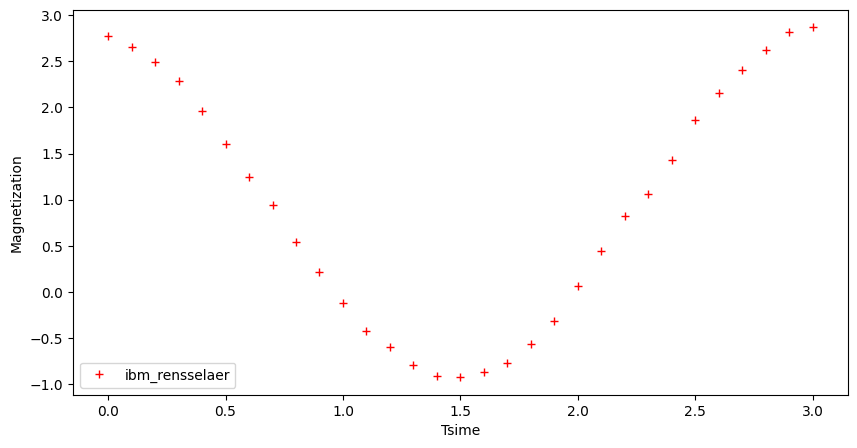

In [59]:
plt.figure(figsize=(10,5))
plt.plot(time_step_list1, mag_values, 'r+',label='ibm_rensselaer')
plt.xlabel('Tsime')
plt.ylabel('Magnetization')
plt.legend()
plt.show()

Compare all the different methods.

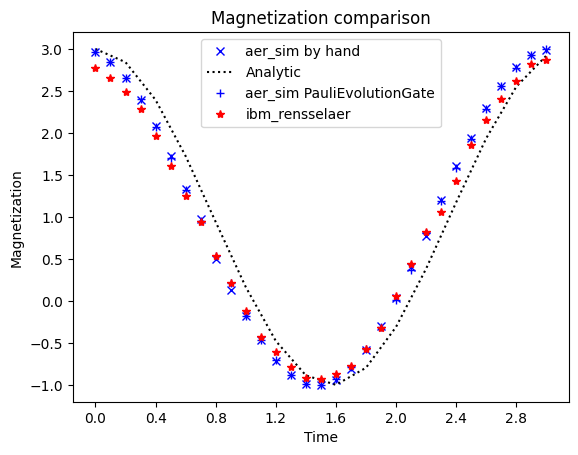

In [67]:
plt.plot(time_list_sim, mag_sim, 'bx', label='aer_sim by hand')
plt.plot(time_step_list_exact, exact_obs_mag, 'k:',label='Analytic')
plt.plot(time_step_list1, sim_mag_values, 'b+',label='aer_sim PauliEvolutionGate')
plt.plot(time_step_list1, mag_values, 'r*',label='ibm_rensselaer')
plt.xlabel('Time')
plt.ylabel('Magnetization')
plt.xticks(np.arange(min(time_step_list_exact), max(time_step_list_exact)+0.2, 0.4))
plt.title(r'Magnetization comparison')
plt.legend()
plt.show()